## SUMMARY

Neural networks are mathematical expressions -

* Many parameters (e.g., weights, biases)
* Loss captures "goodness" of the mode wrt labels
* Goal is to nudge parameters to reduce loss
* Gradient tells us the direction to nudge each parameter in order to `increace` loss
* Update (to `minimize` loss) take the negative gradient multplied by a step size
* `Autograd` engine computes gradients for arbirarily large networks
* Here, we use `Micrograd` to scalers to show how gradients flow across a network w/ backprop
 
Common problem: Set zero grad before backdprop -

* `.grad` for each parameter starts at `0`.
* When we call `.backward()` , we fill in the gradients. 
* We update the data `p.data += -0.01 * p.grad`, but don't flush the grad at each step (!)
* All the updates to grad do a `self.grad +=`, so they accumulate unless we explicity flush it. 
* Useful: https://twitter.com/karpathy/status/1204192394142310400?s=20&t=SCSrRaR-B2OYkZDCLgeGJQ

Neuron is fully connected to its input -

* Input has `nin` values
* Neuron has `nin` weights: `self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]`
* And a single bias: self.b = Value(random.uniform(-1,1))
* Output activation is sum: `act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)`
* Then, a non-linearity is applied: `out = act.tanh()`

A layer simply has `nout` neurons -
    
* self.neurons = [Neuron(nin) for _ in range(nout)]
* Each neuron process all `nin` inputs

An MLP has multiple layers - 
    
* E.g., pass a list of layer sizes `nouts` 
* `sz = [nin] + nouts`
* Build layers: `self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]`

Using mean squared error loss (for regression problem) - 

* The average of the squared differences between actual values and predicted values
* Can use `torch.nn.MSELoss`
* Or `loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))`

In [2]:
import math
import torch
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

`Tensors` are a generalisation of scalars and vectors -

* Vector is one-dimensional tensor
* Matrix is a two-dimensional tensor

In [11]:
vector = np.array([2,5])
tensor_1d = torch.Tensor([2,5])

The length (a.k.a. the magnitude) of vector is the `norm`.

In [14]:
def vector_norm(vector):
    squares = [element**2 for element in vector]
    return sum(squares)**0.5

vector_norm(vector),tensor_1d.norm().item()

(5.385164807134504, 5.385164737701416)

`Slope` of a stright line is rise / run.

Slope of a curve (`Derivative`) can be approximated at any point `h`:

* Zoom in on that point
* Approximate a stright line (e.g., slightly increace input `h`)
* Compute slope of the stright line (e.g., how does function respond)

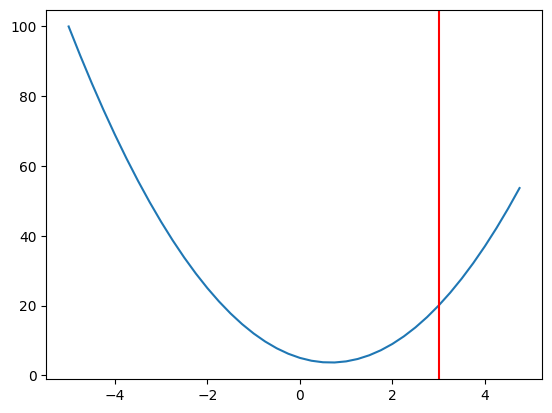

In [15]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.axvline(3,color='r')

In [5]:
h = 0.000001
x = 3
(f(x + h) - f(x))/h

14.000003002223593

Note: as `h` gets too small, the slope goes to zero:
* This is a limitation of floating point arithmatic 
* The representation of numbers in memory is finite

In [6]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

Some `functions are not differentiable`:
    
* E.g., a "V" shaped curve, which will never appear stright as you zoom in  
* Function must of course be defined at `h`
* Function must also be continuous at `h`
* Function must not have a breaking point at `h`

Useful notes on differentiation rules: 

https://aman.ai/primers/math/

`Autograd` engine compute derivatives on neural networks:

* Implements backprop 
* Backprop evaluates gradient of loss wrt weights
* Allows for iterative tuning of weights to minimize loss

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

`Micrograd -` 
* Scalaer autograd engine 
* Scalers are nice b/c not working w/ N-d tensors 
* Tensors are simply for efficiency (parallelization)
* Supports building expression graphs, `a`, `b`, ... 
* Supports forward pass to run expression graph, computing `g`
* Support backward pass, telling us slope of change in output `g` 
* We define some simple `Value` objects to define these expressions

Recall python `classes`:

* `__init__` to initialize
* Operator `+` will call `__add__` method

In [16]:
class Value:
    
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    
a = Value(2.0)
b = Value(-2.0)
c = a + b
c

Value(data=0.0)

Full `class` w/ forward and backward:

In [17]:
class Value:
    
    def __init__(self, data, _children=(), _op='',label=''):
        self.data = data
        self.grad = 0 # no effect on output, by default
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    # The Python __add__() method is called to implement the arithmetic addition operation + 
    def __add__(self, other):
        # Wrap other in Value if it's not Value object
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other),'+')
        def _backward():
            # Propogate and accumulate gradient
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out 
 
    # The Python __mul__() method is called to implement the arithmetic multiplication operation * 
    def __mul__(self, other):
        # Wrap other in Value if it's not Value object
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),'*')
        def _backward():
            # Propogate and accumulate gradient
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out 
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            # Propogate and accumulate gradient
            # First part of expression is local derivative
            # Needs to be chained to out.grad
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        return out 
            
    def __rmul__(self,other): # other * self
        return self*other

    def __radd__(self, other): # other + self
        return self + other
    
    # The Python __truediv__() method is called to implement the normal division operation /
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
        
    def tanh(self):
        x = self.data
        # We know this derivative, so can backprop back through it
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            # Propogate and accumulate gradient
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        # Build topological graph
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        # Set base case
        self.grad = 1.0
        
        # Compute backwards pass
        for node in reversed(topo):
            node._backward()   
    
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0,label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [18]:
a = Value(2.0)
a * 2

Value(data=4.0)

In [19]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [20]:
b = Value(4.0)
a / b

Value(data=0.5)

In [21]:
a - b

Value(data=-2.0)

We can compute how L changes w.r.t. all inputs. 

Know from trivial math - 

* `dL / dd = -2`
* `dL / df = 4`

`Chain rule` multiplies local derivatives - 

* `dL / dc = dL / dd * dd / dc`
* `dd / dc = 1.0`
 
Local derivatives of `add nodes` is 1 - 

* `dd / dc where d = c + e`
* `(f(x+h) - f(x)) / h`
* `(c+h + e) - (c + e) / h = h / h = 1`

In [22]:
# Graph viz to be used later
def trace(root):
    
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Key point - 

* `Add` nodes simply **routes** derivate back to all lead nodes.

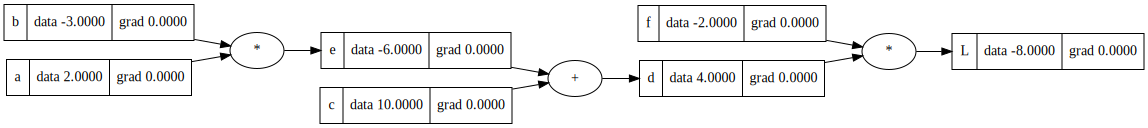

In [23]:
draw_dot(L)

In [13]:
def numerical_gradient():
    
    # pick a step size
    h = 0.001
    
    # Local variables, so we don't mess us global scope
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0,label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0,label='a')
    b = Value(-3.0,label='b')
    c = Value(10.0,label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0,label='f')
    f.data += h
    L = d*f; L.label='L'
    L2 = L.data
    
    print((L2 - L1)/h)
    
numerical_gradient()

3.9999999999995595


Change in loss wrt small change in each input node (weight) numerically - 
* `dL / da = 6`
* `dL / db = -4`
* `dL / dd = -2`
* `dL / dc = -2`
* `dL / de = -2`
* `dL / df = 4`

Internal nodes c and e have **same gradient** as d.

In [14]:
# Add all grads
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0

# Current state of L
L.data

-8.0

In [15]:
# To make L increace (less negative) ... 
# ... change input in the direction of gradient

# Update data 
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

# Run forward pass
e = a*b; e.label='e'
d = e+c; d.label='d'
L = d*f; L.label='L'
L.data

-36.2752

## Neuron mathematical model

* Inputs: `x * W`
* Sum: `sum(x * W)`
* Bias: `b`
* Activation: `squash the output` (e.g., TanH)

`NN are a class of mathematical expressions -` 
* NN are mathematical expressions
* Simulated blob of neural tissue
* `Inputs`: Data and parameters (weights, biases)
* `Forward pass`: Generate predictions
* `Loss function`: accurancy of predictions
* `Backprop`: Get local gradient, which is the direction of increacing loss
* `Gradient descent`: Tune parameters to reduce loss

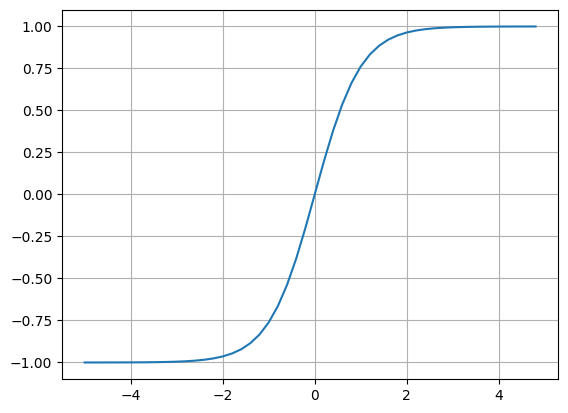

In [16]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [25]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2 (strenth of each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label= 'o'

Work out local derivatie of tanh - 
* `o = tanh(n)`
* `do / dn = 1 - tanh(n)**2`

In [26]:
print("Derivative of Tanh:")
print(1 - o.data**2)

Derivative of Tanh:
0.4999999999999999


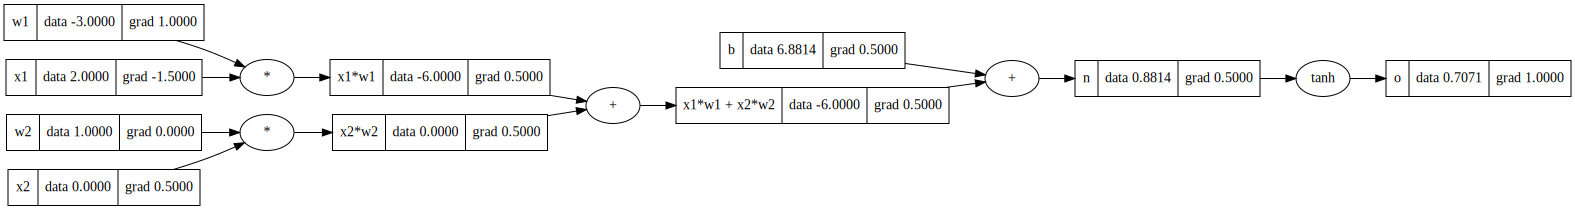

In [27]:
# Set n gradient based on derivative and draw the graph
o.grad = 1.0
n.grad = 0.5

# likewise, we can manually set the remaining gradients
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
draw_dot(o)

Rather than manually setting gradients, we can compute them - 

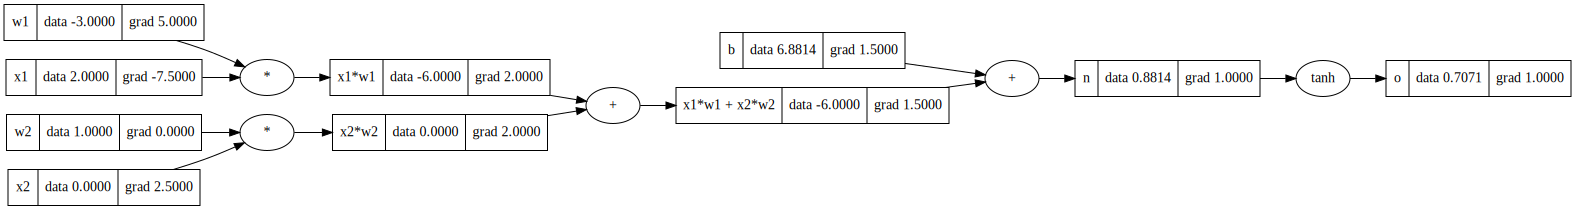

In [28]:
o.backward()
draw_dot(o)

Break up TanH - 

* If you can write the local graient
* Then you can chain it w/ the existin gradient and continue backprop

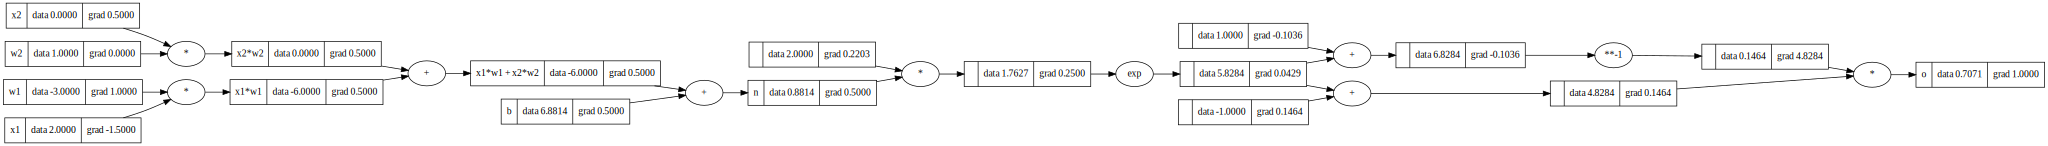

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2 (strenth of each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# Break up TanH
e = (2*n).exp()
o = (e-1)/(e+1)
o.label= 'o'
o.backward()
draw_dot(o)

`Pytorch` uses Tensors, just n-d array of scalar

In [30]:
import torch
import random

# Define the value objects and cast as double (float 64)
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# Returns element from forward pass
print(o.data.item())

0.7071066904050358


In [31]:
# Returns element from forward pass
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [32]:
o.item()

0.7071066904050358

In [33]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

Value(data=0.9634547006430217)


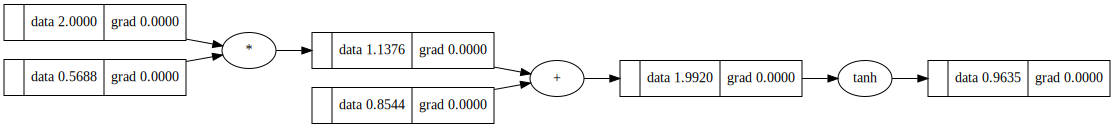

In [34]:
# Initialize neuron w/ 1 input
n=Neuron(1)
# Execute forward pass 
x=[2.0]
# Visualize wx + b
print(n(x))
draw_dot(n(x))

In [35]:
# MLP has many layers 
# Each layer has N Neurons
# Each neuron is fully connected to the input 
x=[2.0,3.0]
l=Layer(2,3)
l(x)

[Value(data=0.9981550023834329),
 Value(data=-0.9665159330117701),
 Value(data=0.6543810337685483)]

In [36]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
# draw_dot(mlp_)
n(x)

Value(data=-0.36602490276864424)

In [37]:
# Input
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
# Predictions
ypred = [n(x) for x in xs]
# Labels
ys = [1.0, -1.0, -1.0, 1.0] 
ypred

[Value(data=-0.36602490276864424),
 Value(data=-0.14313875717394842),
 Value(data=0.06466636517914298),
 Value(data=-0.2572034617257072)]

In [38]:
# Single number that calculate performance of the net (measure how it performs)
# Forward pass
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=5.31431023776036)

In [31]:
# Run back-prop
loss.backward()
print("Neuron weight")
print(n.layers[0].neurons[0].w[0].data)
print("Neuron gradient on the loss")
print(n.layers[0].neurons[0].w[0].grad)

Neuron weight
-0.26032016532543634
Neuron gradient on the loss
0.2604737725852027


`Goal`: Nudge each parameter based on gradient

* We can see all the weights and biases in the MLP
* Gradient vector points in the direction of **increacing** loss
* However, we want to **minimize loss**
* So, we `take the negative gradient` 

In [32]:
# Nudge all parameters by a small amount
for p in n.parameters():
    p.data += -0.01 * p.grad

In [33]:
print("Neuron weight")
print(n.layers[0].neurons[0].w[0].data)
print("Neuron gradient on the loss")
print(n.layers[0].neurons[0].w[0].grad)

Neuron weight
-0.26292490305128835
Neuron gradient on the loss
0.2604737725852027


Weight value went down, which is good:

* `Gradient points in direction of increacing loss`
* Positive gradient means positive change to weight increaces the loss
* So, we take negative of the gradient to reduce the loss
* So, we reduce the value of the weight to reudce the loss

Now, we train:

In [73]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5518329586400404)

In [74]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

Bug! Most common neural net mistakes -

2hr 10min in video: 
 
`Set zero grad before backdprop.`

https://twitter.com/karpathy/status/1204192394142310400?s=20&t=SCSrRaR-B2OYkZDCLgeGJQ

All weights have 

In [75]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    # step
    print(k,loss.data)

0 5.550770326792467
1 2.4364017286797206
2 1.6836425438068567
3 1.0968872356778547
4 0.6705678374240416
5 0.41885880818340726
6 0.2834760123586574
7 0.2063755967834218
8 0.15888974100648615
9 0.12752323059003895
10 0.10560028349087948
11 0.08957631480002458
12 0.07743802847813185
13 0.06797333648765153
14 0.060415781676177574
15 0.054260233726995344
16 0.049161917807152275
17 0.04487835971035974
18 0.04123457645302856
19 0.03810142836624871


Confirm ypred is very close to targets.

In [76]:
ypred

[Value(data=0.9446215063008342),
 Value(data=-0.9334077341904465),
 Value(data=-0.8672030414253764),
 Value(data=0.8861356564611219)]